In [1]:
#Proyecto: Clasificación de galaxias mediante imágenes (clasificación multietiqueta)
#Objetivo: Desarrollar un modelo de aprendizaje automático capaz de clasificar galaxias en múltiples categorías basándose en imágenes astronómicas.

#Importar paquetes necesarios
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

#Configuraciones generales
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
DATA_DIR = '.\Datasets'

print(f'DEVICE: {DEVICE}')
IMG_TRAIN_DIR = os.path.join(DATA_DIR, 'images_training_rev1')
IMG_TEST_DIR = os.path.join(DATA_DIR, 'images_test_rev1')
LABELS_CSV = os.path.join(DATA_DIR, 'training_solutions_rev1.csv')
SUBMISSION_CSV = os.path.join(DATA_DIR, 'all_zeros_benchmark.csv')

DEVICE: cuda


In [2]:
#Preprocesamientos

labels_df = pd.read_csv(LABELS_CSV) #Lectura del archivo CSV de etiquetas
print(f'Labels DataFrame shape: {labels_df.shape}')
print(f'First 8 columns: {labels_df.columns[:8].to_list()}')

bench = pd.read_csv(SUBMISSION_CSV) #Lectura del archivo CSV de benchmark
#Usar el orden de las filas del benchmark para el conjunto de prueba y estar seguros de que las predicciones se alinean correctamente
target_cols = bench.columns[1:].to_list()
print(f'Benchmark DataFrame shape: {bench.shape}')
print(f'Target columns: {target_cols}')

#Asegurarse de que las columnas de etiquetas coincidan con las del benchmark y estén en el mismo orden
missing_taget_cols = [col for col in target_cols if col not in labels_df.columns]
assert len(missing_taget_cols) == 0, f'Missing target columns in labels_df: {missing_taget_cols}'


Labels DataFrame shape: (61578, 38)
First 8 columns: ['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2']
Benchmark DataFrame shape: (79975, 38)
Target columns: ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']


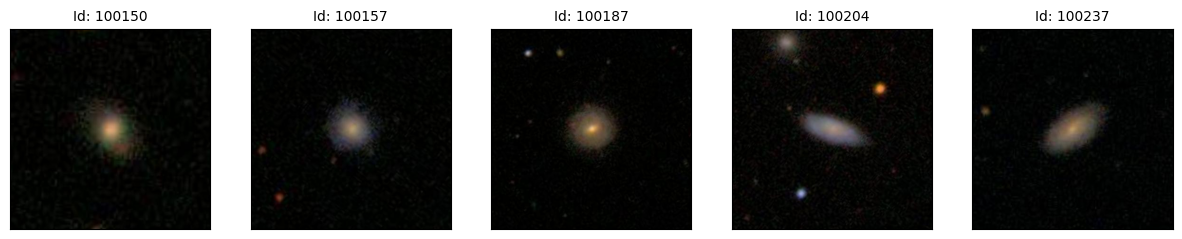

In [3]:
#Visualización de imágenes

def show_image(dir, num_images=5, ids=None):
    fig = plt.figure(figsize=(15, 5))
    for j in range(10, 10 + num_images):
        img_path = os.path.join(dir, str(ids[j]) + '.jpg')
        img = imread(img_path) 
        ax = fig.add_subplot(1, num_images, j - 10 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f'Id: {ids[j]}', fontsize=10)  
    plt.show()

labels_id = labels_df['GalaxyID'].tolist()
show_image(IMG_TRAIN_DIR, num_images=5, ids=labels_id)

In [4]:
#Definir los transformadores de datos

#Redimensionar todas las imágenes a un tamaño fijo (ahora mismo son de 424x424)
SIZE = 224

transform_train = transforms.Compose([
    # transforms.RandomCrop(SIZE, padding=4), #recorte aleatorio con relleno (a veces con relleno a veces no)
    # transforms.RandomHorizontalFlip(), #volteo horizontal aleatorio
    # #transforms.RandomRotation(15),  #rotación aleatoria
    transforms.Resize([SIZE, SIZE]),
    transforms.ToTensor(),

])

transform_test = transforms.Compose([
    transforms.Resize([SIZE, SIZE]),
    transforms.ToTensor()
])



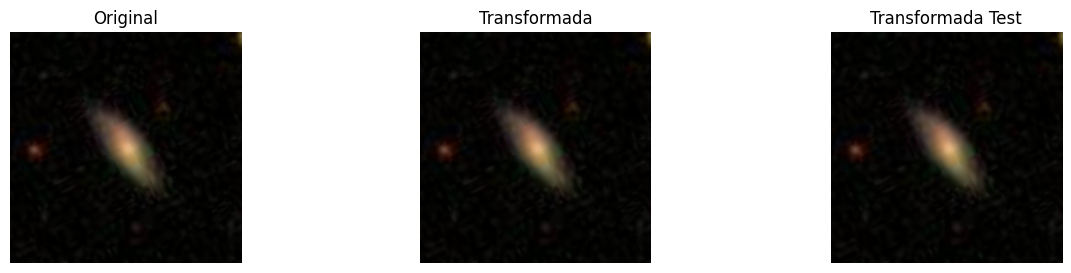

Original image shape: (424, 424)
Transformed image shape (train): (224, 224, 3)
Transformed image shape (test): (224, 224, 3)


In [5]:
#Comprobar los transformadores de datos en imágenes y mostrar una imagen transformada

img_id = labels_id[1]
img_path = os.path.join(IMG_TRAIN_DIR, str(img_id) + '.jpg')
img = Image.open(img_path)

fig = plt.figure(figsize=(15, 3))

# Original
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax.set_title("Original")
ax.axis("off")

# Transformada con train transform
img_transformed = transform_train(img)   
img_transformed = img_transformed.permute(1, 2, 0).numpy()

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_transformed)
ax.set_title("Transformada")
ax.axis("off")

#Transformada con test transform
img_transformed_test = transform_test(img)  
img_transformed_test = img_transformed_test.permute(1, 2, 0).numpy()

ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_transformed_test)
ax.set_title("Transformada Test")
ax.axis("off")

plt.show()

print(f'Original image shape: {img.size}')
print(f'Transformed image shape (train): {img_transformed.shape}')
print(f'Transformed image shape (test): {img_transformed_test.shape}')

In [ ]:
#Crear el dataset personalizado y cargar en el DataLoader

#Dado que no se dispone de las etiquetas del test nos enfocaremos en el dataset de entrenamiento y validación
class GalaxyDataset(Dataset):
    def __init__(self, images_dir, labels_id,  labels, transform=None):
        self.images_dir = images_dir
        self.labels_id = labels_id
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels[self.labels.columns[0]])
    
    def __getitem__(self, idx):
        img_id = self.labels_id[idx]
        img_path = os.path.join(self.images_dir, str(img_id) + '.jpg')
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, label

labels_id = labels_df['GalaxyID'].tolist()
target_cols = bench.columns[1:].to_list()

max_train_size = len(labels_df) - (len(labels_df) // 5) #80% para entrenamiento, 20% para validación
galaxy_train_labels_id = Subset(labels_id, list(range(0, max_train_size))) #muestras para entrenamiento
galaxy_val_labels_id = Subset(labels_id, list(range(max_train_size, len(labels_df)))) #resto para validación

# train_ids = labels_id[:max_train_size]
# val_ids = labels_id[max_train_size:]

# train_labels = labels_df.iloc[:max_train_size][target_cols]
# val_labels = labels_df.iloc[max_train_size:][target_cols]

#Crear los datasets
# galaxy_train_dataset = GalaxyDataset(IMG_TRAIN_DIR, train_ids, train_labels, transform=transform_train)
# galaxy_val_dataset = GalaxyDataset(IMG_TRAIN_DIR, val_ids, val_labels, transform=transform_test)
galaxy_train_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_train_labels_id, labels_df.iloc[galaxy_train_labels_id.indices][target_cols], transform=transform_train)
galaxy_val_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_val_labels_id, labels_df.iloc[galaxy_val_labels_id.indices][target_cols], transform=transform_test)

num_cores = os.cpu_count()
#Crear los DataLoaders
galaxy_train_dl = DataLoader(galaxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
galaxy_val_dl = DataLoader(galaxy_val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print('Num cores / 2: ', num_cores//2)
print(f'Number of training samples: {len(galaxy_train_dataset)}')
print(f'Number of validation samples: {len(galaxy_val_dataset)}')



Num cores / 2:  8
Number of training samples: 49263
Number of validation samples: 12315


In [10]:
#Creacion de un modelo de red neuronal convolucional (CNN) usando la GPU

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=len(target_cols)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) #3 canales de entrada (RGB), 32 filtros (detectar patrones locales borde)
        self.pool1 = nn.MaxPool2d(2, 2) #Reducción de dimensionalidad y extracción de características 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.AvgPool2d(2, 2)

        alto_ancho_final = SIZE // 16  #Reducción de tamaño tras 4 capas de pooling
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * alto_ancho_final * alto_ancho_final, 512) # fc1: salida adaptada a 256 canales  
        self.out = nn.Linear(512, num_classes)
        self.relu = nn.ReLU() #ReLU: introduce no linealidad, permite aprender patrones complejos
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  #Reducción de dimensionalidad y extracción de características
        self.dropout = nn.Dropout(0.25) #Dropout: técnica de regularización para prevenir sobreajuste

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.pool4(self.relu(self.conv4(x)))

        x = self.Flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.out(x)
        return x

model = GalaxyCNN().to(DEVICE)
print(model)

GalaxyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=37, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
import time
start = time.time()
x_batch, y_batch = next(iter(galaxy_train_dl))
end = time.time()
print(f'Tiempo para cargar un batch: {end-start:.2f}s')

#Conprobar la salida del modelo y dimensiones
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)
start = time.time()
outputs = model(x_batch)
end = time.time()
print(f'Tiempo para pasar un batch por el modelo: {end-start:.2f}s')
print(f'Input batch shape: {x_batch.shape}')
print(f'Output batch shape: {outputs.shape}')


Tiempo para cargar un batch: 0.41s


In [ ]:
# Función de pérdida: BCEWithLogitsLoss para clasificación multietiqueta
loss_fn = nn.BCEWithLogitsLoss()

# Optimizador: Adam con tasa de aprendizaje de 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Entrenamiento y validación del modelo
def train_val_model(num_epochs, model, dl_train, dl_val, loss_fn, optimizer, device=DEVICE):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        loss_hist, correct = 0, 0

        for x_batch, y_batch in dl_train:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            pred = model(x_batch)

            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Acumulación de pérdida
            loss_hist += loss.item() * y_batch.size(0)

            # Calcular aciertos multietiqueta
            pred_labels = (torch.sigmoid(pred) > 0.5).float()  
            correct += (pred_labels == y_batch).sum().item()

        epoch_loss = loss_hist / len(dl_train.dataset)
        epoch_acc = correct / (len(dl_train.dataset) * y_batch.size(1))
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        loss_hist, correct = 0, 0
        with torch.no_grad():
            for x_batch, y_batch in dl_val:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)

                loss = loss_fn(pred, y_batch)
                loss_hist += loss.item() * y_batch.size(0)

                pred_labels = (torch.sigmoid(pred) > 0.5).float()
                correct += (pred_labels == y_batch).sum().item()

            epoch_loss = loss_hist / len(dl_val.dataset)
            epoch_acc = correct / (len(dl_val.dataset) * y_batch.size(1))
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, '
              f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

    return train_loss, train_acc, val_loss, val_acc


tr_loss, tr_acc, val_loss, val_acc = train_val_model(NUM_EPOCHS, model, galaxy_train_dl, galaxy_val_dl, loss_fn, optimizer, DEVICE)

In [ ]:
#Graficar las curvas de pérdida y precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_acc, label='Train Acc', color='blue')
plt.plot(val_acc, label='Val Acc', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()